In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb, rgb2gray, rgb2hed
from skimage import data
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel, rank
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.feature import canny
from skimage import feature, measure, segmentation, exposure, morphology
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import csc_matrix, save_npz, csr_matrix
import seaborn as sns

In [2]:
import pandas as pd
from MAESTRO.scATAC_H5Process import write_10X_h5

In [3]:
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [4]:
from skimage.io import imread
from skimage.filters import threshold_otsu, threshold_multiotsu, threshold_niblack, threshold_local
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import disk, dilation, square
from skimage import img_as_ubyte

In [5]:
import sys
sys.path.append("/fs/home/sundongqing/Project/Single_cell/SpatialTranscriptome/Code/")
from SpaceDivider.Utility import *

In [6]:
import h5py
def write_10X_h5(filename, matrix, features, barcodes, genome = 'GRCh38', datatype = 'Peak'):
    """Write 10X HDF5 files, support both gene expression and peaks."""
    f = h5py.File(filename, 'w')
    if datatype == 'Peak':
       M = sparse.csc_matrix(matrix, dtype=np.int8)
    else:
       M = sparse.csc_matrix(matrix, dtype=np.float32)
    B = np.array(barcodes, dtype='|S200')
    P = np.array(features, dtype='|S100')
    GM = np.array([genome]*len(features), dtype='|S10')
    FT = np.array([datatype]*len(features), dtype='|S100')
    AT = np.array(['genome'], dtype='|S10')
    mat = f.create_group('matrix')
    mat.create_dataset('barcodes', data=B)
    mat.create_dataset('data', data=M.data)
    mat.create_dataset('indices', data=M.indices)
    mat.create_dataset('indptr', data=M.indptr)
    mat.create_dataset('shape', data=M.shape)
    fet = mat.create_group('features')
    fet.create_dataset('_all_tag_keys', data=AT)
    fet.create_dataset('feature_type', data=FT)
    fet.create_dataset('genome', data=GM)
    fet.create_dataset('id', data=P)
    fet.create_dataset('name', data=P)
    f.close()

In [8]:
count_df = pd.read_csv("../../../Data/Mouse_brain_Adult_GEM_bin1_sub.tsv", sep ="\t", header = 0)
count_df

geneID     x     y  MIDCounts
0        0610005C13Rik   732    10          1
1        0610009B22Rik   154   120          1
2        0610009B22Rik   566   710          1
3        0610009B22Rik     4   600          1
4        0610009B22Rik   503   906          1
...                ...   ...   ...        ...
1526498         mt-Nd6   190   581          1
1526499         mt-Nd6  1013   435          2
1526500         mt-Nd6   162    83          1
1526501         mt-Nd6  1049   409          3
1526502         mt-Nd6   656  1030          2

[1526503 rows x 4 columns]

In [9]:
count_df['x_y'] = count_df['x'].astype(str) + '_' + count_df['y'].astype(str)
count_df

geneID     x     y  MIDCounts       x_y
0        0610005C13Rik   732    10          1    732_10
1        0610009B22Rik   154   120          1   154_120
2        0610009B22Rik   566   710          1   566_710
3        0610009B22Rik     4   600          1     4_600
4        0610009B22Rik   503   906          1   503_906
...                ...   ...   ...        ...       ...
1526498         mt-Nd6   190   581          1   190_581
1526499         mt-Nd6  1013   435          2  1013_435
1526500         mt-Nd6   162    83          1    162_83
1526501         mt-Nd6  1049   409          3  1049_409
1526502         mt-Nd6   656  1030          2  656_1030

[1526503 rows x 5 columns]

In [10]:
gene_spot = count_df['MIDCounts'].groupby([count_df['x_y'], count_df['geneID']]).sum()
gene_spot

x_y    geneID  
0_0    Apmap       1
       Atp6v0e2    1
       Cables1     2
       Comt        1
       Rps15a      1
                  ..
9_995  Strn4       1
       Uba52       2
       Wdr6        1
9_998  Vmp1        2
       mt-Nd4      4
Name: MIDCounts, Length: 1526503, dtype: int64

In [224]:
spot_expr_mat, gene_list, spot_list = longdf_to_mat(gene_spot)
spot_expr_mat

<17943x747800 sparse matrix of type '<class 'numpy.int64'>'
	with 1526503 stored elements in Compressed Sparse Column format>

In [228]:
count_h5_file = "../../../Data/Mouse_brain_Adult_GEM_bin1_sub.h5"
write_10X_h5(filename = count_h5_file, matrix = spot_expr_mat, features = gene_list, barcodes = spot_list, genome = 'GRCm38', datatype = 'Gene')

In [11]:
coord_df = count_df.drop_duplicates(subset = ['x_y'])
coord_df = coord_df[["x", "y", "x_y"]]
coord_df

x     y       x_y
0         732    10    732_10
1         154   120   154_120
2         566   710   566_710
3           4   600     4_600
4         503   906   503_906
...       ...   ...       ...
1526487  1063   655  1063_655
1526491   287   721   287_721
1526499  1013   435  1013_435
1526500   162    83    162_83
1526502   656  1030  656_1030

[747800 rows x 3 columns]

In [201]:
binSize = 20
count_df['x_bin'] = (count_df['x']/binSize).astype(np.uint32)*binSize
count_df['y_bin'] = (count_df['y']/binSize).astype(np.uint32)*binSize
count_df_bin_umi = count_df['MIDCounts'].groupby([count_df['x_bin'], count_df['y_bin']]).sum()
count_df_bin_umi
x_bin = set(str(x[0]) for x in count_df_bin_umi.index)
y_bin = set(str(x[1]) for x in count_df_bin_umi.index)
x_bindic = dict(zip(x_bin, range(0, len(x_bin))))
y_bindic = dict(zip(y_bin, range(0, len(y_bin))))
rows = [x_bindic[str(x[0])] for x in count_df_bin_umi.index]
cols = [y_bindic[str(x[1])] for x in count_df_bin_umi.index]
count_df_bin_umi_mat_sparse = csr_matrix((count_df_bin_umi.values, (rows, cols)))
count_bin_umi_df = pd.DataFrame(count_df_bin_umi)
count_bin_umi_df

MIDCounts
x_bin y_bin           
0     0            384
      20           307
      40           334
      60           314
      80           347
...                ...
1180  1100         426
      1120         347
      1140         305
      1160         347
      1180         368

[3600 rows x 1 columns]

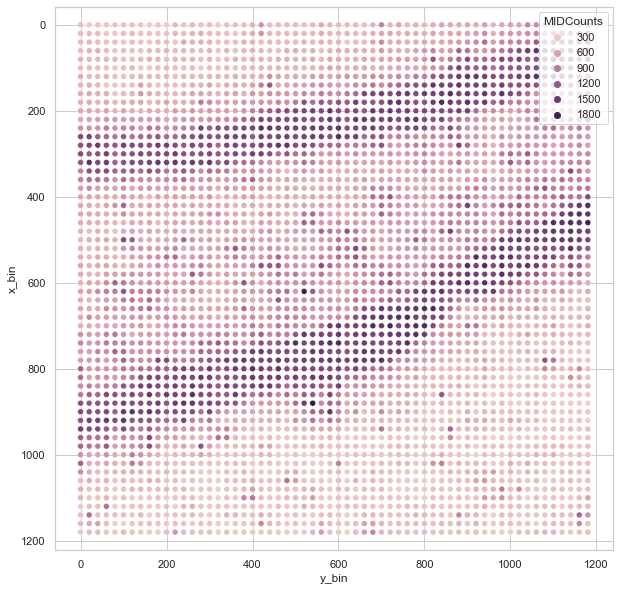

In [206]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="y_bin", y="x_bin",
                hue="MIDCounts",
                data=count_bin_umi_df, ax=ax)
plt.ylim(1200, 0)
plt.axis('equal')
plt.show()

In [8]:
img_path = "../../../../Data/Mouse_brain_Adult_sub.tif"
img = imread(img_path)

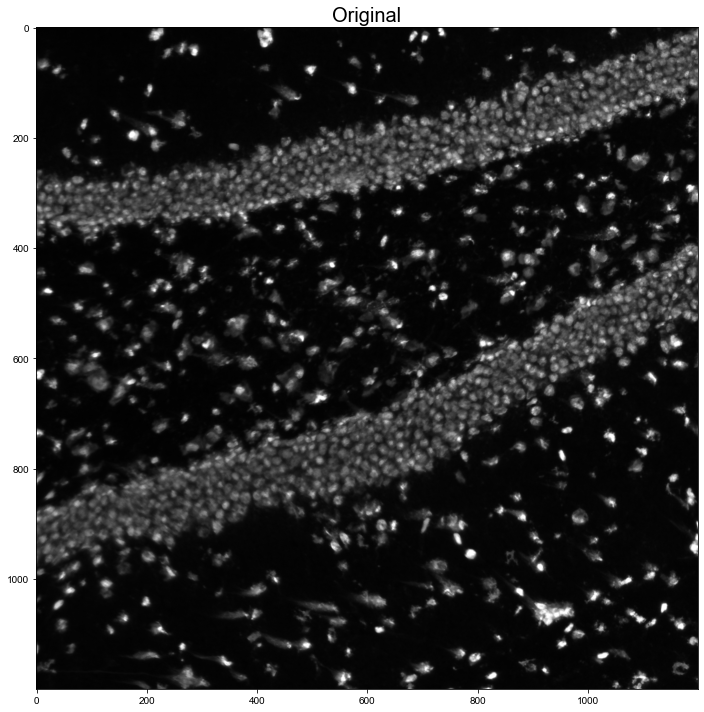

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(img, cmap="gray")
ax.set_title("Original", fontsize = 20)
plt.tight_layout()

In [10]:
img.shape

(1200, 1200)

In [11]:
img_top = img
threshold = threshold_multiotsu(img_top, 3)[0]
# threshold = threshold_otsu(img_top) - 20
mask_top = img_top > threshold
img_mask_top = img_top.copy()
img_mask_top[~mask_top] = 0

In [12]:
np.where(mask_top)[0].shape

(385572,)

In [13]:
threshold - 20

20

In [14]:
threshold_multiotsu(img_top, 3)

array([ 40, 105])

In [21]:
# Create an artificial color close to the original one
local_thresh_top = threshold_local(img_top, block_size = 51, offset=0)
local_top = img_top > local_thresh_top
# eq_mask_top = img_top_eq > (eq_thresh_top - 0.05)

# img_fg_top = img_top_eq.copy()
# img_mask_top = img_top_eq.copy()

# img_fg_top[~eq_fg_top] = 0
# img_mask_top[~eq_mask_top] = 0

In [22]:
local_thresh_top

array([[ 6.82396005,  6.82377145,  6.8233917 , ..., 65.32042588,
        65.93567353, 66.24726819],
       [ 6.82784567,  6.82766691,  6.82730688, ..., 65.79234914,
        66.40838381, 66.7203856 ],
       [ 6.83557951,  6.83542064,  6.83510042, ..., 66.71870675,
        67.33606484, 67.64875374],
       ...,
       [ 7.81542722,  7.82487277,  7.84368178, ..., 12.81811062,
        12.90439105, 12.94827862],
       [ 7.80924299,  7.81868283,  7.83747935, ..., 12.67306628,
        12.75611225, 12.79835181],
       [ 7.80630703,  7.8157436 ,  7.83453306, ..., 12.59968374,
        12.68108996, 12.72249407]])

In [23]:
local_thresh_top.shape

(1200, 1200)

In [24]:
local_top = img_top > local_thresh_top

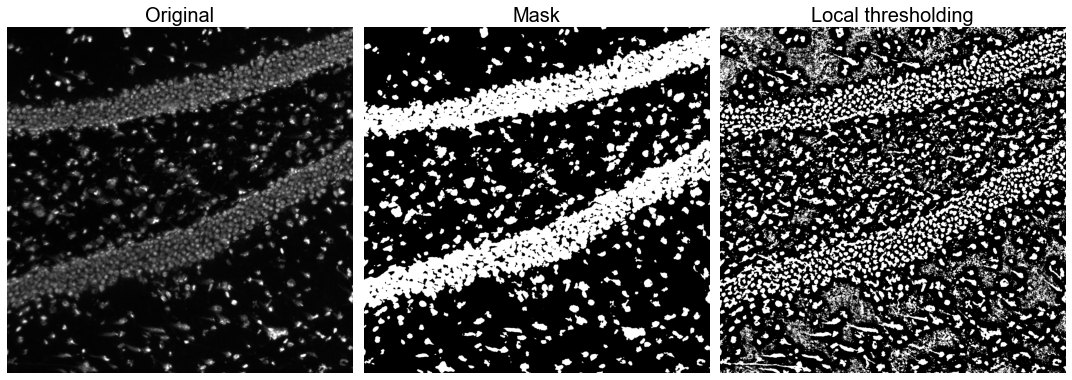

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7), sharex=True, sharey=True)

# ax.imshow(mark_boundaries(img, segments_fz, color = (0,0,0)))
# ax.set_title("Felzenszwalbs's method")
# ax.imshow(mark_boundaries(img, segments_slic))
# ax.set_title('SLIC')
# ax.imshow(mark_boundaries(img, segments_quick, color = (0,0,0)))
# ax.set_title('Quickshift')
ax[0].imshow(img_top, cmap="gray")
ax[0].set_title("Original", fontsize = 20)
ax[1].imshow(mask_top, cmap = "gray")
ax[1].set_title('Mask', fontsize = 20)
ax[2].imshow(local_top, cmap = "gray")
ax[2].set_title('Local thresholding', fontsize = 20)
for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
# plt.show()
# plt.savefig("ssDNA_cropped_local_threshold.pdf", dpi = 400)

In [26]:
mask_local_top = img_mask_top > local_thresh_top
otsu_local = np.logical_and(local_top,mask_local_top)
np.where(otsu_local)[0].shape

(256846,)

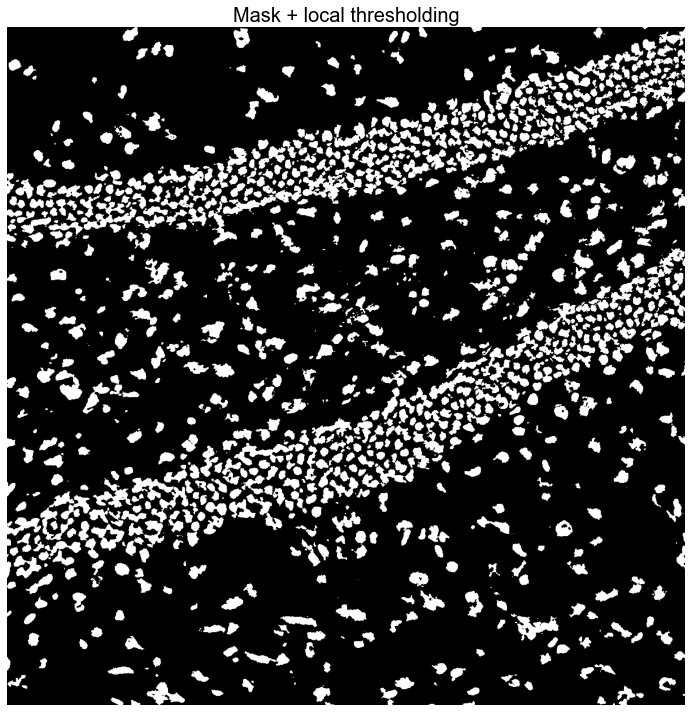

In [27]:
mask_local_top = img_mask_top > local_thresh_top
otsu_local = np.logical_and(local_top,mask_local_top)
otsu_local_hole_rm = morphology.remove_small_holes(otsu_local)

fig, ax = plt.subplots(figsize=(10, 10))

# ax.imshow(mark_boundaries(img, segments_fz, color = (0,0,0)))
# ax.set_title("Felzenszwalbs's method")
# ax.imshow(mark_boundaries(img, segments_slic))
# ax.set_title('SLIC')
# ax.imshow(mark_boundaries(img, segments_quick, color = (0,0,0)))
# ax.set_title('Quickshift')
ax.imshow(otsu_local, cmap="gray")
ax.set_title("Mask + local thresholding", fontsize = 20)
# ax[1].imshow(mask_top, cmap = "gray")
# ax[1].set_title('Mask', fontsize = 20)
ax.axis('off')

plt.tight_layout()
# plt.show()
# plt.savefig("ssDNA_cropped_local_threshold_mask.pdf", dpi = 400)

In [28]:
distance_local_top = ndi.distance_transform_edt(otsu_local)

In [29]:
local_max_coords = feature.peak_local_max(distance_local_top, min_distance= 6, exclude_border=False)

In [30]:
local_max_coords.shape

(1663, 2)

In [31]:
local_max_coords.shape[0]

1663

In [32]:
local_max_mask = np.zeros(distance_local_top.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

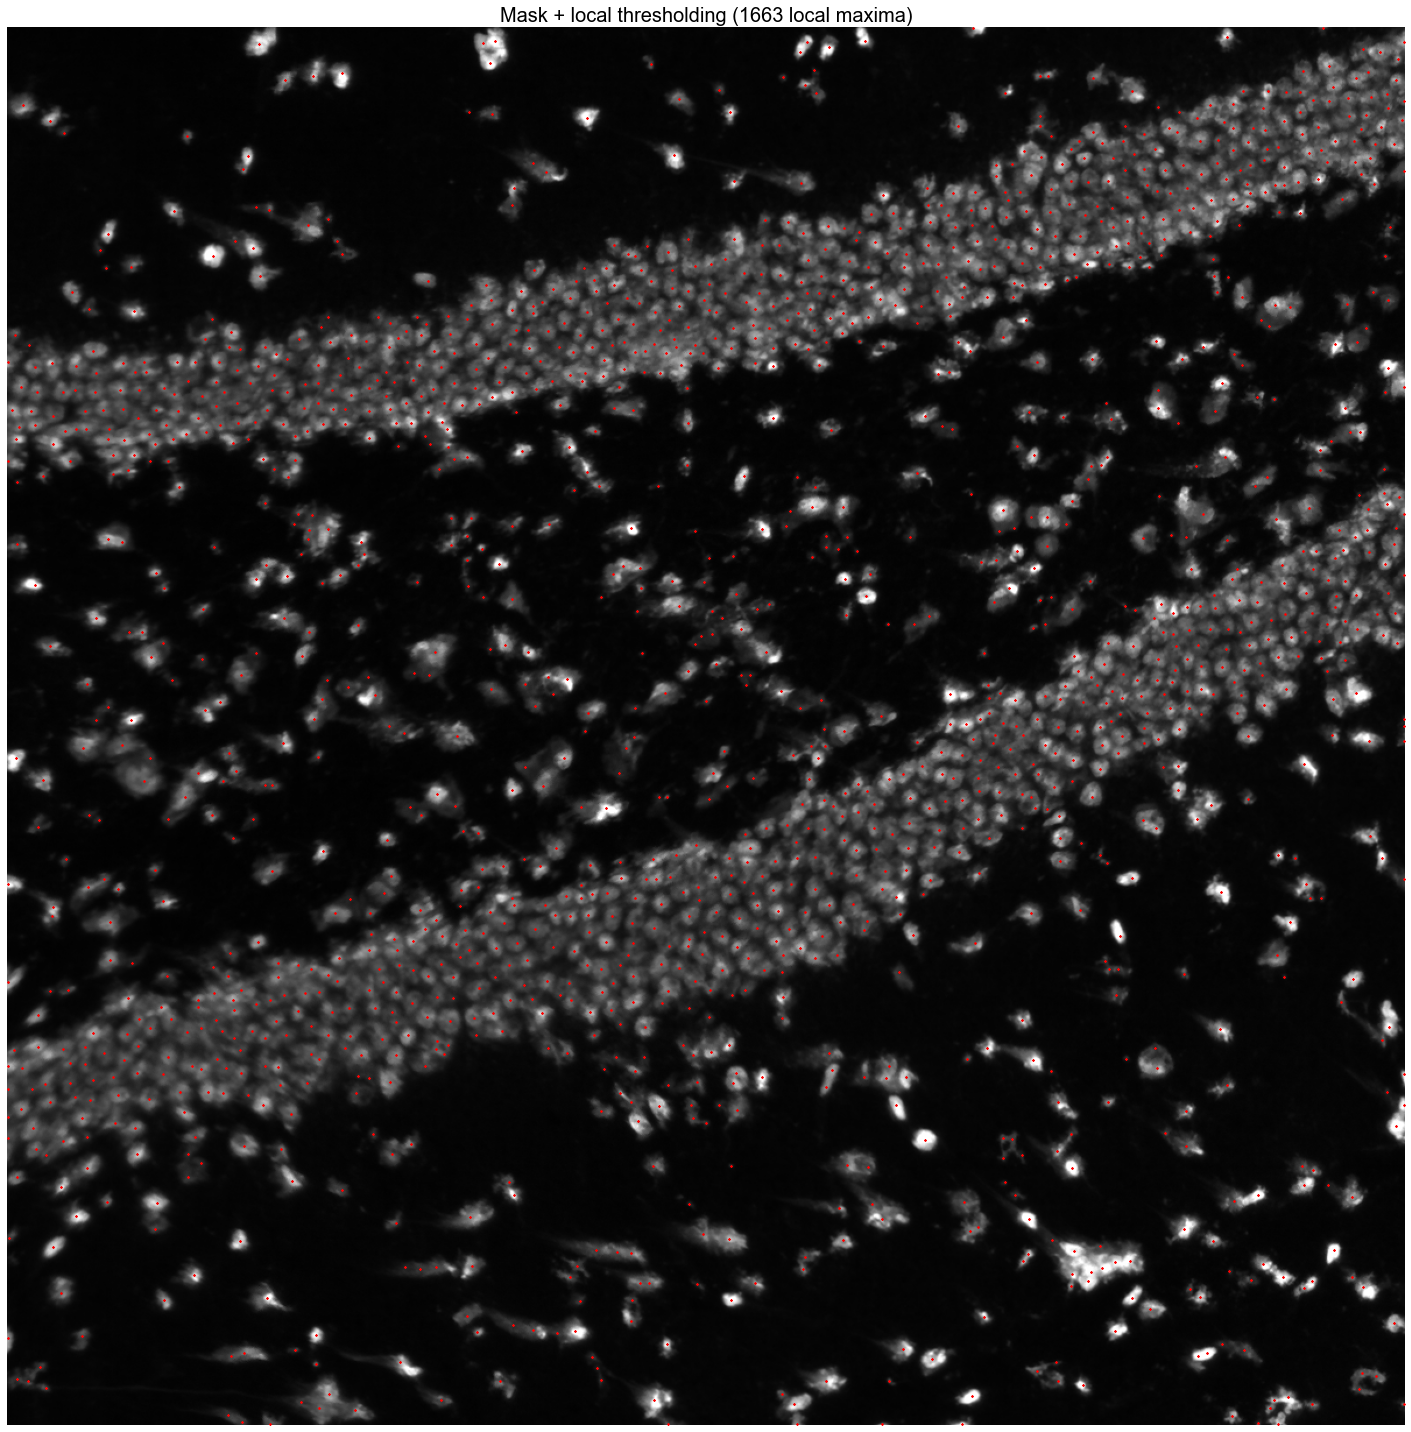

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img_top, cmap='gray')
ax.plot(local_max_coords[:,1], local_max_coords[:,0], 'r*', markersize = 2)
ax.set_title('Mask + local thresholding (%s local maxima)' % local_max_coords.shape[0], fontsize = 20)
ax.axis('off')
plt.tight_layout()
plt.show()
# plt.savefig("ssDNA_cropped_local_threshold_local_maxima.pdf", dpi = 400)

In [34]:
segmented_cells = segmentation.watershed(-distance_local_top, markers, mask = otsu_local)
print(f"Watershed number of segments: {len(np.unique(segmented_cells))}")

Watershed number of segments: 1664


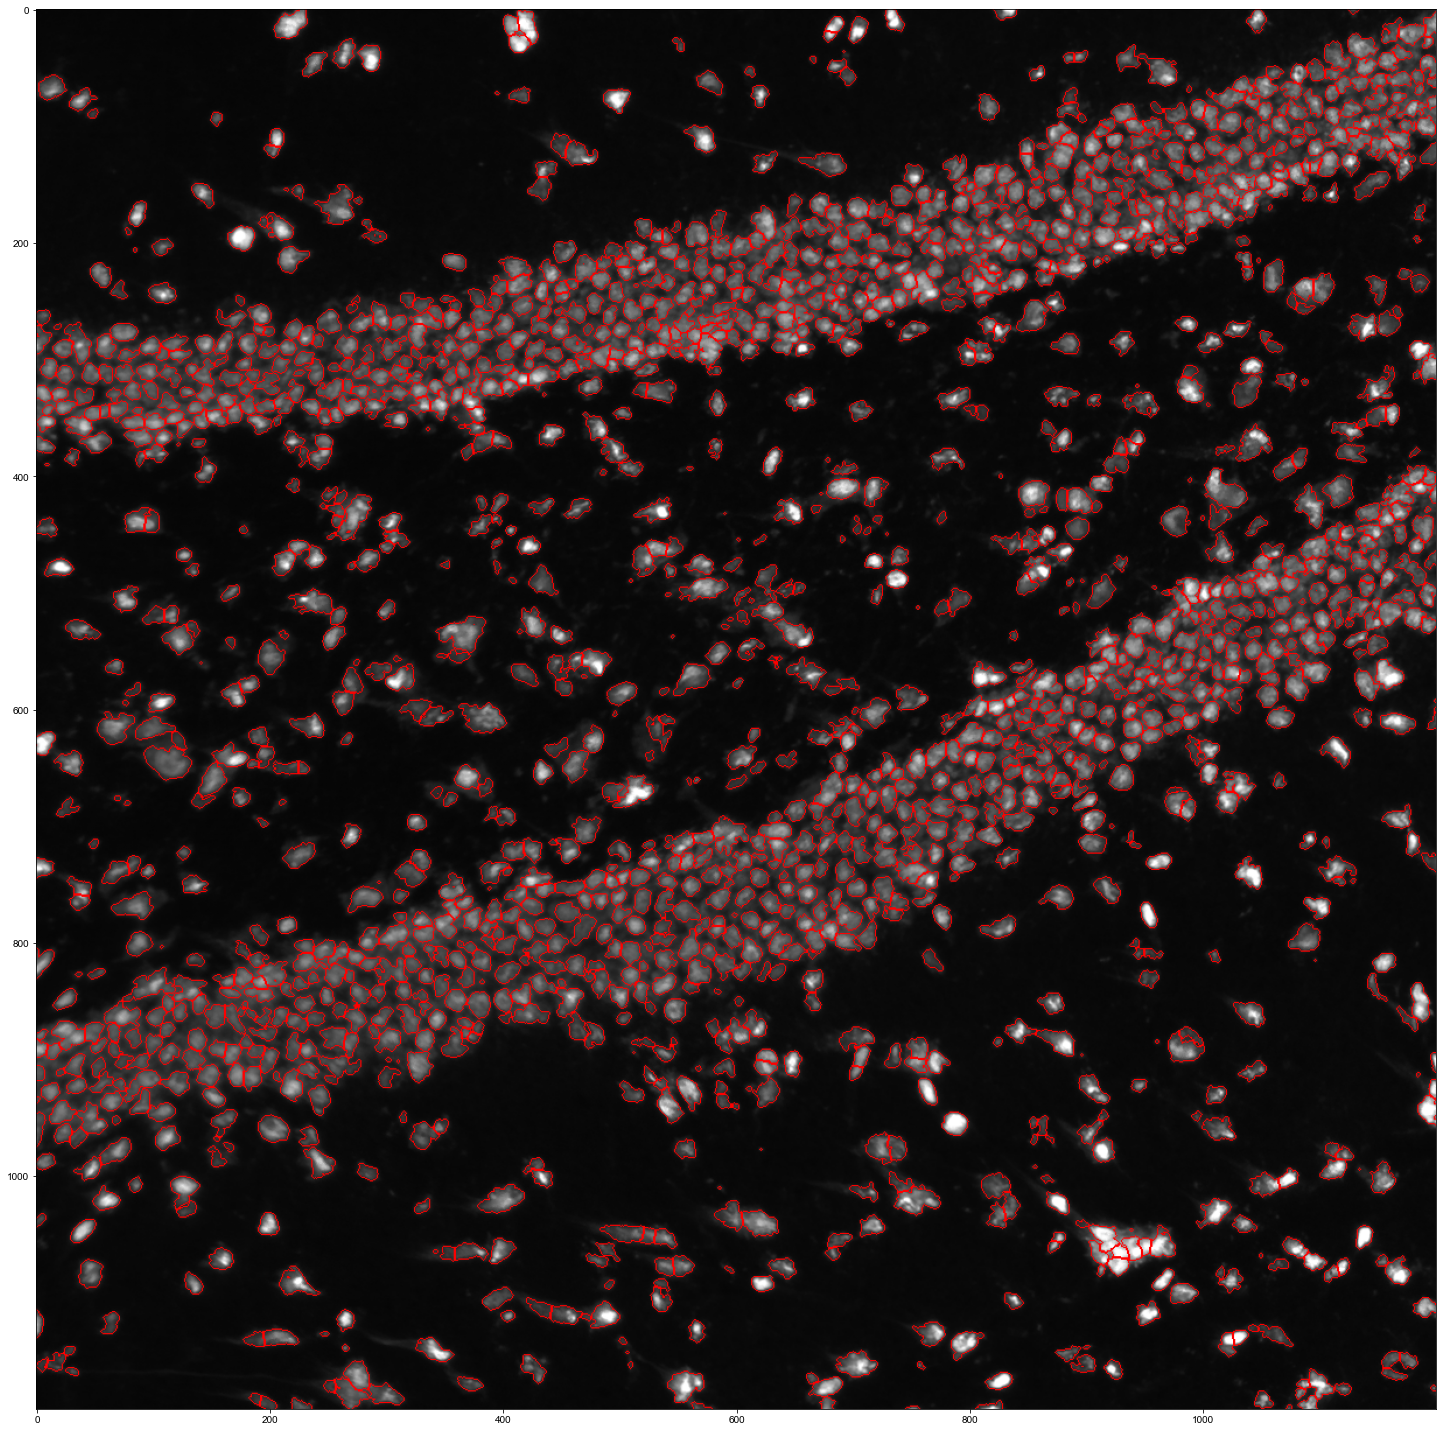

In [35]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(mark_boundaries(img_top, segmented_cells, color = (1,0,0)))
# ax.axis('off')
plt.tight_layout()

plt.show()
# plt.savefig("ssDNA_cropped_local_threshold_local_maxima_watershed_0410.pdf", dpi = 400)
# plt.savefig("ssDNA_cropped_local_threshold_local_maxima_watershwd.pdf", dpi = 400)

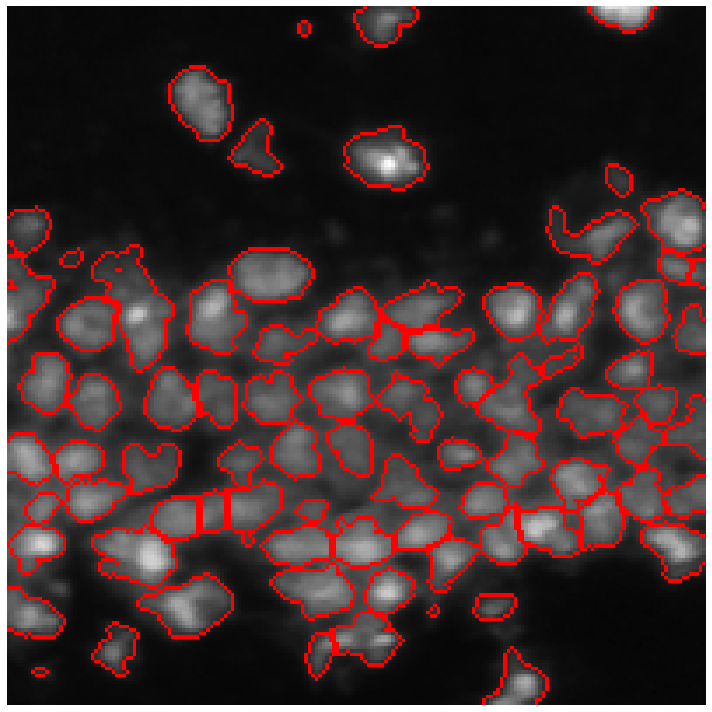

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(mark_boundaries(img_top[200:400, :200], segmented_cells[200:400, :200], color = (1,0,0)))
ax.axis('off')
plt.tight_layout()

# plt.show()
plt.savefig("Sub_200_watershed.pdf", dpi = 400)

In [180]:
watershed_seg_file = 'Segmented_nucleus_matrix_conventional_watershed.npz'
segmented_cells_mat = csc_matrix(segmented_cells, dtype=np.int32)
save_npz(watershed_seg_file, segmented_cells_mat)

In [181]:
props = measure.regionprops_table(segmented_cells, 
                          properties=['label', 'area','centroid',
                                      'equivalent_diameter_area'])
props_df =  pd.DataFrame(props)
props_df.to_csv("Segmented_nucleus_property_conventional_watershed.txt", sep = "\t", index = False)
props_df

label  area   centroid-0   centroid-1  equivalent_diameter_area
0         1   126     3.126984   830.531746                 12.666025
1         2    22     0.954545  1128.863636                  5.292567
2         3   198     9.611111  1046.131313                 15.877702
3         4   220    10.190909   419.568182                 16.736568
4         5   199     9.211055   735.135678                 15.917747
...     ...   ...          ...          ...                       ...
1599   1600    18  1198.611111   751.388889                  4.787307
1600   1601    51  1197.764706   814.647059                  8.058239
1601   1602    33  1196.606061   824.727273                  6.482045
1602   1603    10  1198.100000  1073.800000                  3.568248
1603   1604   119  1194.882353  1090.714286                 12.309163

[1604 rows x 5 columns]

In [173]:
props_df["area"].quantile([0,0.05, 0.25, 0.5, 0.75, 1])

0.00      1.0
0.05     16.0
0.25    100.0
0.50    166.0
0.75    235.0
1.00    951.0
Name: area, dtype: float64

In [174]:
from skimage.segmentation import watershed, expand_labels
expanded8 = expand_labels(segmented_cells, distance=8)

In [182]:
watershed_seg_file = 'Segmented_cells_matrix_conventional_watershed.npz'
expanded8_mat = csc_matrix(expanded8, dtype=np.int32)
save_npz(watershed_seg_file, segmented_cells_mat)

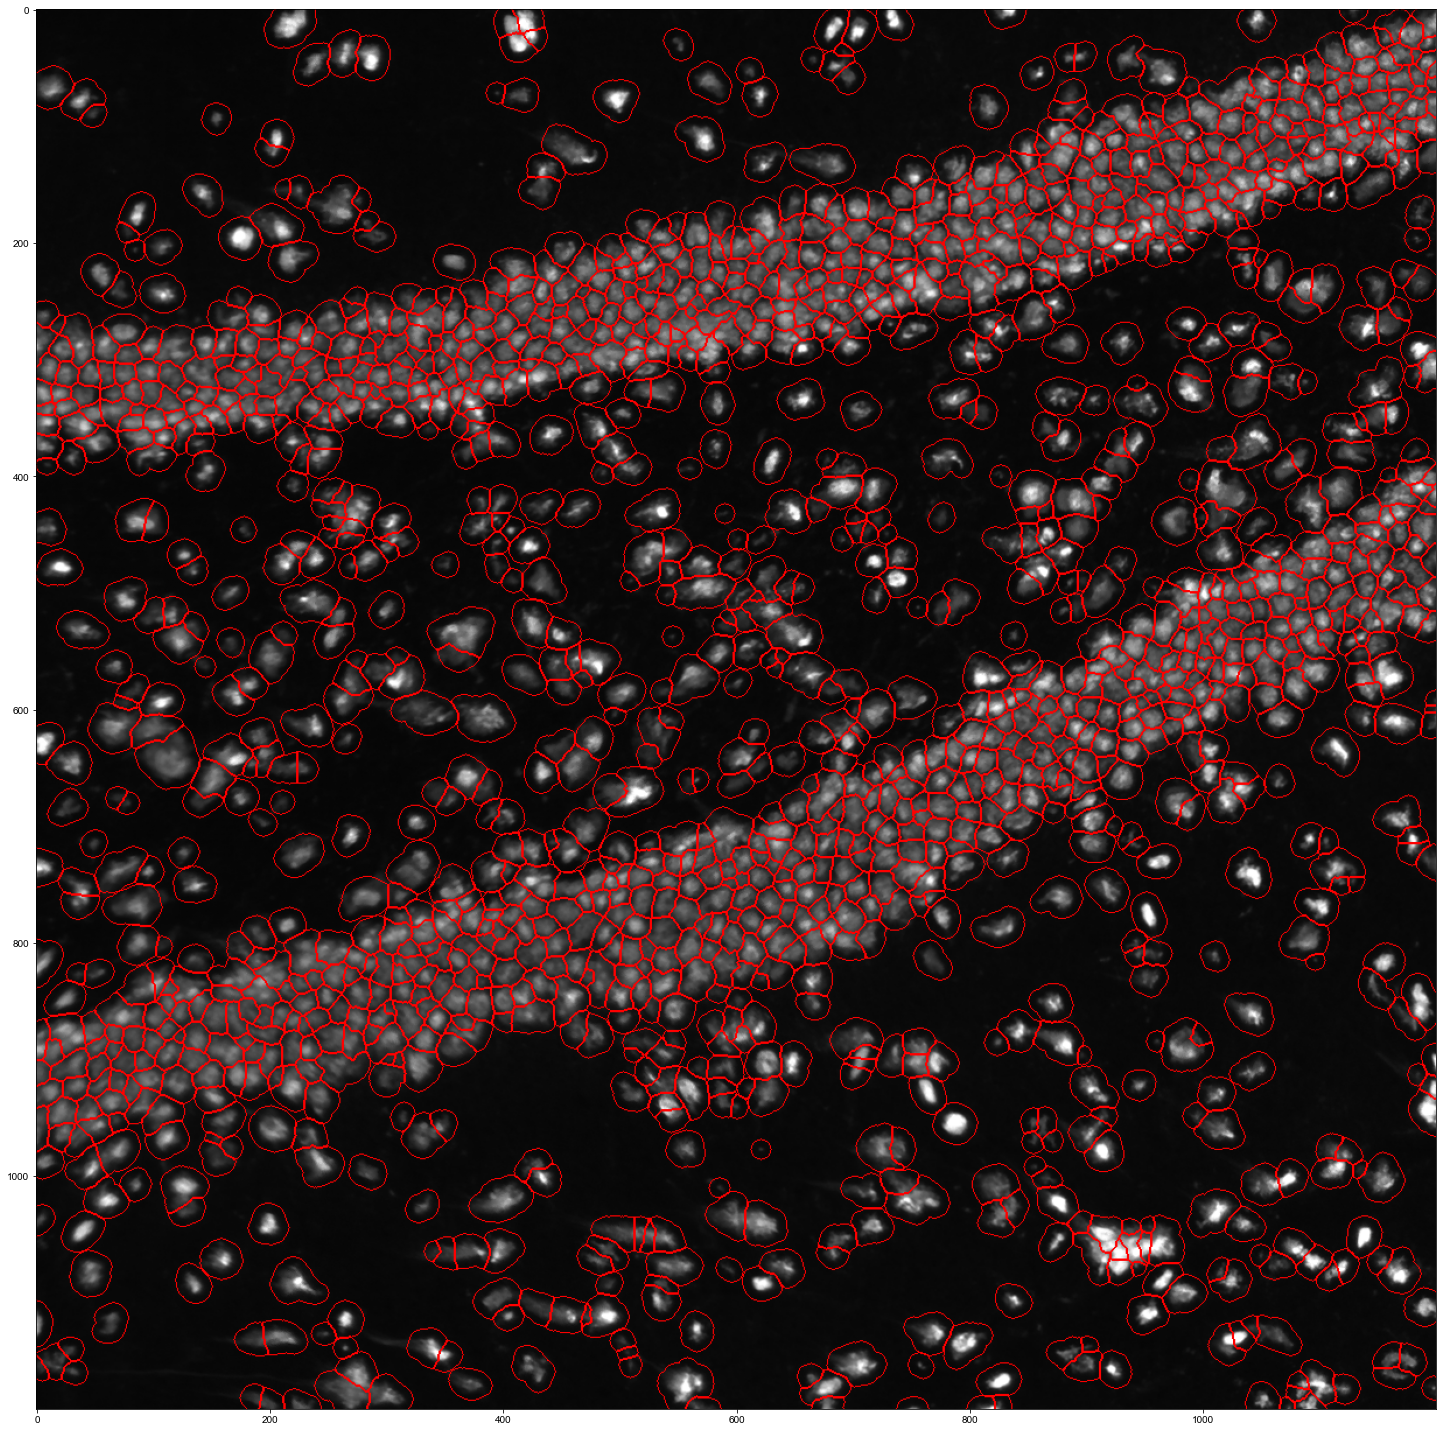

In [175]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(mark_boundaries(img_top, expanded8, color = (1,0,0)))
# ax.axis('off')
plt.tight_layout()

plt.show()
# plt.savefig("ssDNA_cropped_local_threshold_local_maxima_watershed_0410.pdf", dpi = 400)
# plt.savefig("ssDNA_cropped_local_threshold_local_maxima_watershwd.pdf", dpi = 400)

In [183]:
props_expanded = measure.regionprops_table(expanded8, 
                          properties=['label', 'area','centroid',
                                      'equivalent_diameter_area'])
props_df_expanded =  pd.DataFrame(props_expanded)
props_df_expanded.to_csv("Segmented_cells_property_conventional_watershed.txt", sep = "\t", index = False)
props_df_expanded

label  area   centroid-0   centroid-1  equivalent_diameter_area
0         1   448     6.506696   830.497768                 23.883285
1         2   208     4.240385  1128.913462                 16.273716
2         3   700    11.835714  1045.944286                 29.854107
3         4   415     8.508434   422.359036                 22.986831
4         5   673    11.826152   735.677563                 29.272687
...     ...   ...          ...          ...                       ...
1599   1600   207  1195.251208   751.140097                 16.234549
1600   1601   222  1194.522523   810.671171                 16.812471
1601   1602   161  1193.645963   827.732919                 14.317527
1602   1603   106  1195.207547  1071.886792                 11.617375
1603   1604   237  1194.447257  1091.177215                 17.371176

[1604 rows x 5 columns]

In [177]:
props_df_expanded['area'].quantile([0, 0.25, 0.5, 0.75, 1])

0.00      52.00
0.25     258.75
0.50     384.00
0.75     599.25
1.00    1956.00
Name: area, dtype: float64

In [212]:
segmented_nucleus_df = pd.DataFrame(segmented_cells)
segmented_nucleus_df["x"] = segmented_nucleus_df.index
segmented_nucleus_long_df = pd.melt(segmented_nucleus_df, id_vars = "x", 
                                     value_vars = segmented_nucleus_df.columns[0:-1],
                                     var_name = "y",
                                     value_name = "Cell_ID")
segmented_nucleus_long_df["Nucleus"] = 0
segmented_nucleus_long_df.loc[segmented_nucleus_long_df["Cell_ID"] > 0, "Nucleus"] = 1
segmented_nucleus_long_df['x_y'] = segmented_nucleus_long_df['x'].astype(str) + '_' + segmented_nucleus_long_df['y'].astype(str)
segmented_nucleus_long_df_barcode = pd.merge(coord_df, segmented_nucleus_long_df[['x_y','Nucleus','Cell_ID',]], how = 'left', on = 'x_y')
segmented_nucleus_long_df_barcode = segmented_nucleus_long_df_barcode.sort_values(['x', 'y'])
segmented_nucleus_long_df_barcode.to_csv("Segmented_nucleus_coord_conventional_watershed.txt", sep = "\t", index = False)

In [210]:
coord_df

x     y       x_y
0         732    10    732_10
1         154   120   154_120
2         566   710   566_710
3           4   600     4_600
4         503   906   503_906
...       ...   ...       ...
1526487  1063   655  1063_655
1526491   287   721   287_721
1526499  1013   435  1013_435
1526500   162    83    162_83
1526502   656  1030  656_1030

[747800 rows x 3 columns]

In [221]:
segmented_cells_df = pd.DataFrame(expanded8)
segmented_cells_df["x"] = segmented_cells_df.index
segmented_cells_long_df = pd.melt(segmented_cells_df, id_vars = "x", 
                                 value_vars = segmented_cells_df.columns[0:-1],
                                 var_name = "y",
                                 value_name = "Expansion")
segmented_cells_long_df["Nucleus"] = 0
segmented_cells_long_df.loc[segmented_nucleus_long_df["Cell_ID"] > 0, "Nucleus"] = 1
segmented_cells_long_df['x_y'] = segmented_cells_long_df['x'].astype(str) + '_' + segmented_cells_long_df['y'].astype(str)
segmented_cells_long_df_barcode = pd.merge(coord_df, segmented_cells_long_df[['x_y','Nucleus','Expansion',]], how = 'left', on = 'x_y')
segmented_cells_long_df_barcode = segmented_cells_long_df_barcode.sort_values(['x', 'y'])
segmented_cells_long_df_barcode.loc[segmented_cells_long_df_barcode['Expansion'] == 0, 'Expansion'] = np.nan
segmented_cells_long_df_barcode.to_csv("Segmented_cells_coord_conventional_watershed.txt", sep = "\t", index = False)

In [216]:
segmented_cells_long_df_barcode

x     y        x_y  Nucleus  Expansion
69774      0     0        0_0        0        NaN
322685     0     1        0_1        0        NaN
581620     0     2        0_2        0        NaN
353633     0     3        0_3        0        NaN
719669     0     5        0_5        0        NaN
...      ...   ...        ...      ...        ...
631430  1199  1191  1199_1191        0        NaN
522574  1199  1192  1199_1192        0        NaN
650347  1199  1193  1199_1193        0        NaN
96099   1199  1195  1199_1195        0        NaN
668605  1199  1199  1199_1199        0        NaN

[747800 rows x 5 columns]

In [217]:
segmented_cells_long_df_barcode['Expansion'].count()

436807

In [219]:
segmented_nucleus_long_df_barcode['Nucleus'].sum()

177900

In [220]:
segmented_cells_long_df_barcode['Nucleus'].sum()

177900

In [230]:
count_df_watershed = pd.merge(count_df, segmented_nucleus_long_df_barcode[['x_y', 'Cell_ID']], how = "right", on = 'x_y')

In [232]:
count_df_watershed = count_df_watershed.loc[count_df_watershed['Cell_ID'] != 0, :]
count_df_watershed

geneID     x     y  MIDCounts        x_y  x_bin  y_bin  Cell_ID
128        Cmss1     0   228          1      0_228      0    220        9
129      Ppp2r2b     0   229          3      0_229      0    220        9
387       Ndufs5     0   731          1      0_731      0    720        5
388       Zbtb20     0   731          1      0_731      0    720        5
389      Hspa12a     0   733          1      0_733      0    720        5
...          ...   ...   ...        ...        ...    ...    ...      ...
1526438   Tceal3  1199  1073          5  1199_1073   1180   1060     1603
1526445    Lrrc7  1199  1086          1  1199_1086   1180   1080     1604
1526446     Copa  1199  1087          1  1199_1087   1180   1080     1604
1526447   Prpf19  1199  1087          1  1199_1087   1180   1080     1604
1526448     Cd81  1199  1091          4  1199_1091   1180   1080     1604

[434230 rows x 8 columns]

In [237]:
count_df_watershed['Cell_ID'].unique().shape

(1595,)

In [234]:
gene_nucleus = count_df_watershed['MIDCounts'].groupby([count_df_watershed['Cell_ID'], count_df_watershed['geneID']]).sum()
gene_nucleus

Cell_ID  geneID  
1        AI593442    1
         Akap11      4
         Aldoc       2
         Arhgap5     3
         Arl3        1
                    ..
1604     Tmsb4x      1
         Tspan7      1
         Tuba1a      1
         Zfhx3       2
         mt-Nd1      3
Name: MIDCounts, Length: 368236, dtype: int64

In [235]:
nucleus_expr_mat, nucleus_gene_list, nucleus_list = longdf_to_mat(gene_nucleus)
nucleus_expr_mat

<15162x1595 sparse matrix of type '<class 'numpy.int64'>'
	with 368236 stored elements in Compressed Sparse Column format>

In [238]:
count_h5_file = "Segmented_nucleus_merged_conventional_watershed.h5"
write_10X_h5(filename = count_h5_file, matrix = nucleus_expr_mat, features = nucleus_gene_list, barcodes = nucleus_list, genome = 'GRCm38', datatype = 'Gene')